# **Sentiment Analysis Using Various Deep Learning Models** -- CONTINUES

This notebook is the continuation of notebook 04a.
We use this new notebook because the following model needs specific libraries versions to run.

## **2. Install necessary libraries**

In [2]:
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.0 MB/s eta 0:00:

In [3]:
def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0


## **2. Importing Libraries**

First, we import all the necessary libraries for data manipulation, model building, and evaluation.

In [5]:
# Standard library imports
import os
import re

# Numerical and data processing libraries
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Hugging Face Transformers
import transformers
from transformers import BertTokenizer, TFBertModel, logging
logging.set_verbosity_error()

# Gensim for word embeddings
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

# NLTK for natural language processing
import nltk
from nltk.data import find

# Scikit-learn for machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Matplotlib for plotting
import matplotlib.pyplot as plt


## **3. Loading the Dataset**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_VERY_VERY_FINAL.csv'
df = pd.read_csv(CSV_path)
df.head()

Mounted at /content/drive


,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class,news_label
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,[-9.65170786e-02 -6.67401850e-02 2.26862580e-...,1,-0.011845,1,0
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,[-3.15038592e-01 8.39137062e-02 2.63236046e-...,1,0.005470,2,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,[-5.72552562e-01 1.90420046e-01 2.98330992e-...,3,0.012617,2,1
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,[-6.08102679e-01 -1.03185527e-01 1.87640250e-...,2,0.093773,2,1
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,[-7.72164404e-01 1.47608727e-01 -2.20909327e-...,3,0.063339,2,1


## **4. Data Sampling and Splitting**

We sample 2,000 positive and 2,000 negative headlines to create a balanced dataset. We then split the data into training and validation sets using an 80/20 split.

In [7]:
negative_df_full = df[df['news_label'] == 0]
positive_df_full = df[df['news_label'] == 1]
print("Total positive news: ", len(negative_df_full))
print("Total negative news: ", len(positive_df_full))

Total positive news:  4056
Total negative news:  2566


In [8]:
# Randomly sample 2000 rows for each class for training and validation
negative_df_sampled = negative_df_full.sample(n=2000, random_state=42)
positive_df_sampled = positive_df_full.sample(n=2000, random_state=42)

# Identify the leftover data for testing
negative_test = negative_df_full.drop(negative_df_sampled.index)
positive_test = positive_df_full.drop(positive_df_sampled.index)

# Combine the leftover data for the testing dataset
test = pd.concat([positive_test, negative_test], ignore_index=True)

# Split the sampled data into training and validation sets (80/20 split)
positive_train, positive_val = train_test_split(positive_df_sampled, random_state=42, test_size=0.2)
negative_train, negative_val = train_test_split(negative_df_sampled, random_state=42, test_size=0.2)

# Combine the positive and negative samples for training and validation
train = pd.concat([positive_train, negative_train], ignore_index=True)
val = pd.concat([positive_val, negative_val], ignore_index=True)

# Separate features and labels for training, validation, and testing datasets
X_train = train['title']
y_train = train['news_label']

X_val = val['title']
y_val = val['news_label']

X_test = test['title']
y_test = test['news_label']

# Display the sizes of the datasets
print("Training set size:", train.shape)
print("Validation set size:", val.shape)
print("Testing set size:", test.shape)

Training set size: (3200, 31)
Validation set size: (800, 31)
Testing set size: (2622, 31)


## **5. Modeling Using BERT + CNN**

In [9]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Function to tokenize data
def tokenize_data(texts, max_len):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    return inputs

# Define max sequence length
MAX_SEQUENCE_LENGTH = 128

# Tokenize training, validation, and test data
X_train_tokens = tokenize_data(X_train, MAX_SEQUENCE_LENGTH)
X_val_tokens = tokenize_data(X_val, MAX_SEQUENCE_LENGTH)
X_test_tokens = tokenize_data(X_test, MAX_SEQUENCE_LENGTH)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [10]:
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters=[64, 64, 32],
                          kernel_sizes=[2, 3, 4],
                          dropout=0.5,
                          hidden_size=128,
                          learning_rate=1e-5):
    # Partially freeze BERT layers
    for layer in bert_cnn_model.layers[:-4]:
        layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_outputs = bert_cnn_model(bert_inputs)
    sequence_output = bert_outputs.last_hidden_state

    conv_layers = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='valid',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        )(sequence_output)
        pooled = tf.keras.layers.GlobalMaxPooling1D()(conv)
        conv_layers.append(pooled)

    cnn_output = tf.keras.layers.Concatenate()(conv_layers)
    dropout_layer = tf.keras.layers.Dropout(rate=dropout)(cnn_output)

    hidden_layer = tf.keras.layers.Dense(
        hidden_size,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name='hidden_layer'
    )(dropout_layer)
    hidden_layer = tf.keras.layers.Dropout(rate=dropout)(hidden_layer)

    output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden_layer)

    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=output_layer
    )

    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return classification_model

In [12]:
for layer in bert_model.layers:
    if 'pooler' in layer.name:
        layer.trainable = False

# Instantiate the model
classification_model = create_bert_cnn_model(bert_model, max_sequence_length=MAX_SEQUENCE_LENGTH)

# Train the model
history = classification_model.fit(
    [X_train_tokens['input_ids'],
     X_train_tokens['token_type_ids'],
     X_train_tokens['attention_mask']],
    y_train,
    validation_data=(
        [X_val_tokens['input_ids'],
         X_val_tokens['token_type_ids'],
         X_val_tokens['attention_mask']],
        y_val
    ),
    epochs=5,
    batch_size=32
)


Epoch 1/5


100/100 [==============================] - 136s 849ms/step - loss: 1.4083 - accuracy: 0.5059 - val_loss: 1.0916 - val_accuracy: 0.6538
Epoch 2/5
100/100 [==============================] - 82s 821ms/step - loss: 1.1359 - accuracy: 0.5666 - val_loss: 1.0729 - val_accuracy: 0.6750
Epoch 3/5
100/100 [==============================] - 84s 838ms/step - loss: 1.0868 - accuracy: 0.6231 - val_loss: 1.0357 - val_accuracy: 0.6900
Epoch 4/5
100/100 [==============================] - 88s 882ms/step - loss: 1.0413 - accuracy: 0.6681 - val_loss: 1.0126 - val_accuracy: 0.7100
Epoch 5/5
100/100 [==============================] - 85s 847ms/step - loss: 0.9847 - accuracy: 0.7312 - val_loss: 1.0280 - val_accuracy: 0.6925


In [14]:
# # Save the trained BERT model
# classification_model.save('/content/drive/MyDrive/DATASCI-266_FinalProject/BERT_CNN_binary_tokenizer')


In [11]:
# classification_model=keras.models.load_model('/content/drive/MyDrive/DATASCI-266_FinalProject/BERT_CNN_binary_tokenizer')

ValueError: The two structures don't have the same nested structure.

First structure: type=tuple str=(({'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None)}, None, None, None, None, None, None, None, None, None, None, None, None, True), {})

Second structure: type=tuple str=(({'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_ids_attention_mask'), 'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_ids_input_ids'), 'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_ids_token_type_ids')}, None, None, None, None, None, None, None, None, None, None, None, None, True), {})

More specifically: The two dictionaries don't have the same set of keys. First structure has keys type=list str=['input_ids'], while second structure has keys type=list str=['attention_mask', 'input_ids', 'token_type_ids']
Entire first structure:
(({'input_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})
Entire second structure:
(({'attention_mask': ., 'input_ids': ., 'token_type_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})

### **5.1 Model testing**

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = classification_model.evaluate(
    [X_test_tokens['input_ids'],
     X_test_tokens['token_type_ids'],
     X_test_tokens['attention_mask']],
    y_test
)

print(f"Test Accuracy: {test_accuracy}")

82/82 [==============================] - 26s 283ms/step - loss: 0.9211 - accuracy: 0.7784
Test Accuracy: 0.7784134149551392


In [14]:
y_pred = classification_model.predict([X_test_tokens['input_ids'], X_test_tokens['token_type_ids'], X_test_tokens['attention_mask']])
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary predictions

82/82 [==============================] - 25s 262ms/step


### 5.2 **Confusion Matrix and headlines examples**

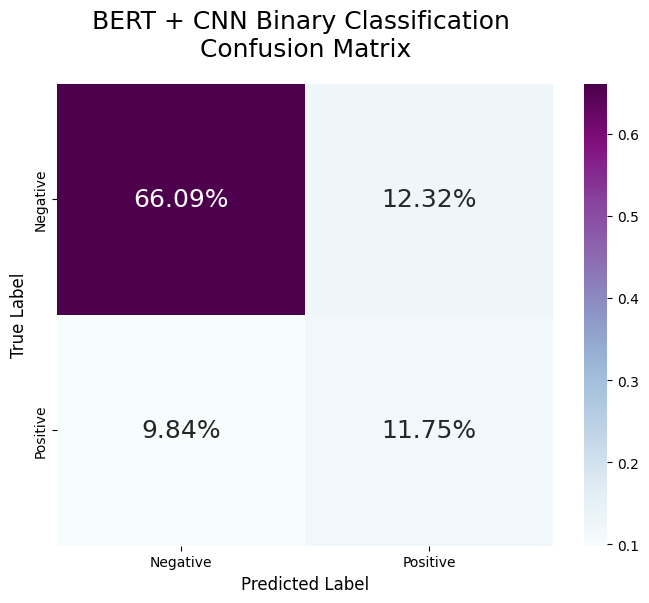

In [15]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('BERT + CNN Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_CNN+BERT.png', transparent=True)
plt.show()

In [16]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred.flatten()}) # Use y_pred.flatten() instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                text  true_label  \
0  Steven Spielberg’s ‘The Fabelmans’ Wins Best D...           1   
1  Austin Butler Accepts Win for ‘Elvis’— With a ...           1   
3  Move Over Alabama, Georgia Is the New Giant of...           1   

   predicted_label  
0                1  
1                1  
3                1  

True Negatives:
                                                  text  true_label  \
566  The Rare Heart Phenomenon Thought to Have Caus...           0   
567               Opinion | Joe Biden, the El Paso Kid           0   
571    Opinion | The Peril of Ignoring the Middle East           0   

     predicted_label  
566                0  
567                0  
571                0  

False Positives:
                                                  text  true_label  \
568                ‘Spare’ Review: Titled and Entitled           0   
569  Jerrod Carmichael on Why He Said Yes to Hostin...           0   
570  Gold

,text,true_label,predicted_label
2,Oil and Gas Are Back and Booming,1,0
7,"Lost at Sea for 24 Days, This Man Survived on ...",1,0
8,Tesla Stock Is More Popular Than Ever Among In...,1,0
